In [46]:
import os
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, random_split
import torch
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import torchvision.utils 
import matplotlib.pyplot as plt
import numpy as np

In [47]:
class LandscapeDataset(Dataset):
    #Initializes the directories which images consist and transforms 
    def __init__(self,img_dir_gray,img_dir_color,transform=None):
        self.img_dir_gray = img_dir_gray
        self.img_dir_color = img_dir_color
        self.color_images=os.listdir(f'{img_dir_color}')
        self.gray_images=os.listdir(f'{img_dir_gray}')
        self.transform=transform
    
    #The __len__ function returns the number of samples in our dataset.
    def __len__(self):
        return(len(self.gray_images))
    '''The __getitem__ function loads and returns a sample from the dataset at the given index idx. 
    Based on the index, it identifies the image’s location on disk, converts that to a tensor using read_image, retrieves the corresponding label from the csv data in self.img_labels, 
    calls the transform functions on them (if applicable), and returns the tensor image and corresponding label in a tuple'''
    


    def __getitem__(self, idx):
        color_img_name = self.color_images[idx]
        gray_img_name = self.gray_images[idx]

        color_img_path = os.path.join(self.img_dir_color, color_img_name)
        gray_img_path = os.path.join(self.img_dir_gray, gray_img_name)

        color_img = read_image(color_img_path) / 255
        gray_img = read_image(gray_img_path) / 255

        if self.transform:
            color_img = self.transform(color_img)
            gray_img = self.transform(gray_img)

        return color_img, gray_img

        
        

In [48]:
transform=transforms.Compose([transforms.Resize((64,64))])
dataset=LandscapeDataset('landscapeImages/gray/gray/','landscapeImages/color/color/',transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
batch_size=64
train_set, test_set = random_split(dataset, [train_size, test_size], generator=torch.Generator())

train_loader=DataLoader(train_set,batch_size=batch_size)
test_loader=DataLoader(test_set,batch_size=batch_size)

In [49]:
print(len(train_loader))

90


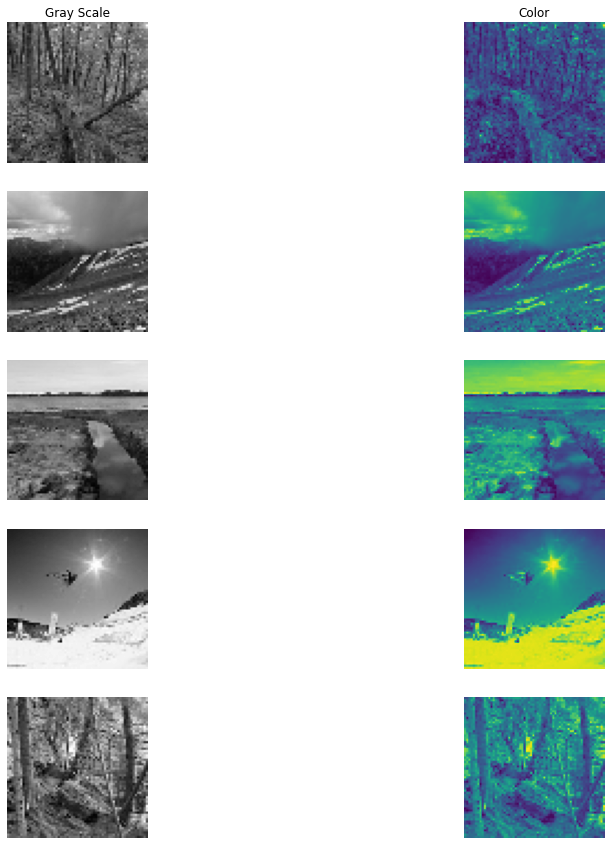

In [50]:
def show_images(color, gray):
    fig, axs = plt.subplots(5, 2, figsize=(15, 15))
    axs[0, 0].set_title('Gray Scale')
    axs[0, 1].set_title('Color')

    for i in range(5):
        # For grayscale images
        axs[i, 0].imshow(gray[i][0], cmap='gray')
        axs[i, 0].axis('off')

        # For color images
        axs[i, 1].imshow(color[i][0])
        axs[i, 1].axis('off')

    plt.show()

color, gray = next(iter(train_loader))
show_images(color, gray)

In [51]:
class Generator(nn.Module):
    def __init__(self,img_size):#,latent_size
        super(Generator,self).__init__()
        self.gen=nn.Sequential(
        
            nn.ConvTranspose2d(1,16,kernel_size=(5,5),stride=1),
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(16,32,kernel_size=(3,3),stride=1),
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(32,32,kernel_size=(3,3),stride=1),
            nn.LeakyReLU(inplace=True),
            
            nn.Conv2d(32, 32, kernel_size=(5, 5), stride=1),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=1),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(64, 64, kernel_size=(5, 5), stride=1),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=1),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=1),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=1, padding=1),
            nn.Tanh()
        
        )
                # Define the upsampling layers
        self.upsample_layers = nn.ModuleList([
            nn.ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=1),
            nn.ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=1),
            nn.ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=1),
            nn.ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=1)
        ])
        
    def forward(self, x):
        out = self.gen(x)

        # Apply upsampling layers
        for layer in self.upsample_layers:
            out = nn.functional.leaky_relu(layer(out), inplace=True)

        return out        

In [52]:
class Discriminator(nn.Module):
    def __init__(self, img_dim):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=7, stride=1, padding=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=7, stride=1, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4* 4, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 16),
            nn.ReLU(inplace=True),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.disc(x)
        #print("Shape before fully connected layers:", x.shape)  # Add this line to check the shape
        x = torch.flatten(x, 1)  # Flatten the output of the convolutional layers
        x = self.fc_layers(x)
        return x


In [58]:
lr = 0.0002
lr_disc = 0.0002
lr_gan = 0.00002
beta_1 = 0.5 
beta_2 = 0.999
image_dim = 64 * 64 * 3
image_size = 64 * 64 * 1
#batch_size = 32
num_epochs = 10

In [59]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [60]:
discriminator= Discriminator(image_dim).to(device)
generator = Generator(image_size).to(device)

In [61]:
opt_disc = optim.Adam(discriminator.parameters(), lr=lr,betas=(beta_1, beta_2))#
opt_gen = optim.Adam(generator.parameters(), lr=lr,betas=(beta_1, beta_2))#
criterion = nn.BCELoss()

Epoch [1/10] Batch 0/90                 Loss D: 0.6946, Loss G: 0.6439



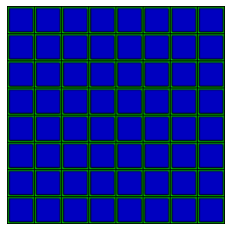

Epoch [2/10] Batch 0/90                 Loss D: 0.0004, Loss G: 7.3444



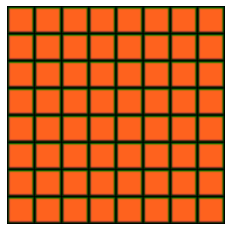

Epoch [3/10] Batch 0/90                 Loss D: 0.4803, Loss G: 0.5131



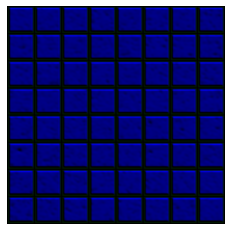

Epoch [4/10] Batch 0/90                 Loss D: 0.1315, Loss G: 6.0375



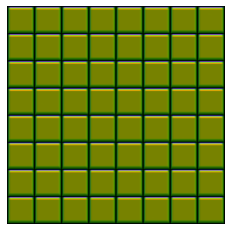

Epoch [5/10] Batch 0/90                 Loss D: 0.7736, Loss G: 0.6963



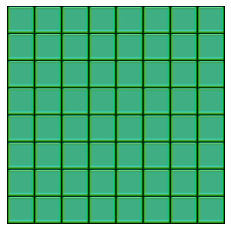

Epoch [6/10] Batch 0/90                 Loss D: 0.4888, Loss G: 0.8214



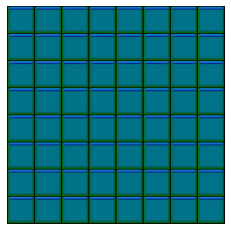

Epoch [7/10] Batch 0/90                 Loss D: 0.0036, Loss G: 5.0310



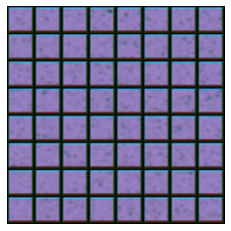

Epoch [8/10] Batch 0/90                 Loss D: 0.1083, Loss G: 2.4585



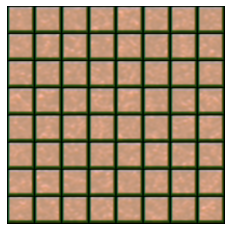

Epoch [9/10] Batch 0/90                 Loss D: 0.4746, Loss G: 2.3218



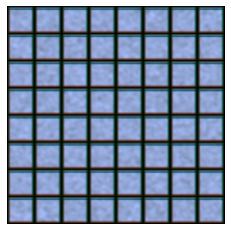

Epoch [10/10] Batch 0/90                 Loss D: 0.5811, Loss G: 0.9795



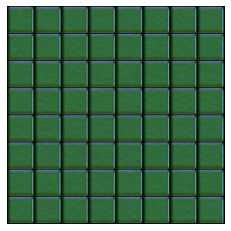

In [62]:
for epoch in range(num_epochs):
    for batch_idx,(color_img,gray_img) in tqdm (enumerate(train_loader),total=len(train_loader)):
        color_img=color_img.to(device)
        gray_img=gray_img.to(device)
        #print(gray_img)
        fake=generator(gray_img)
        disc_real = discriminator(color_img).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = discriminator(fake.detach()).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        discriminator.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()

        # Train the Generator
        output = discriminator(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        generator.zero_grad()
        lossG.backward()
        opt_gen.step()
        if batch_idx == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}] Batch {batch_idx}/{len(train_loader)} \
                Loss D: {lossD:.4f}, Loss G: {lossG:.4f}"
            )

    # Generate samples after each epoch
    with torch.no_grad():
        fixed_noise = torch.randn(64,1,64,64).to(device)
        fake = generator(fixed_noise)
        fake_images = fake.cpu()
        img_grid_fake = torchvision.utils.make_grid(fake_images, nrow=8, normalize=True)
        plt.imshow(np.transpose(img_grid_fake, (1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()

In [65]:
# Save the trained model
save_path = 'model_colorize_generator.pth'
torch.save(generator.state_dict(), save_path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


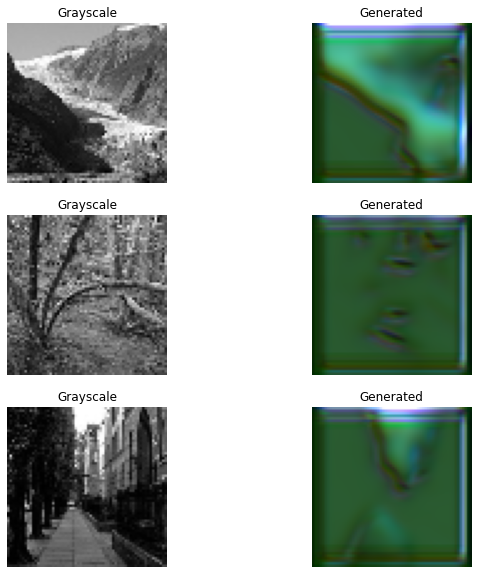

In [66]:
# Set the model to evaluation mode
generator.eval()

# Initialize lists to store results
all_test_color = []
all_test_gray = []
all_test_generated = []

# Iterate over the test dataset
with torch.no_grad():
    for test_color_batch, _ in test_loader:  # Assuming the test_loader returns color images and their labels (which we don't need)
        test_gray_batch = torch.mean(test_color_batch, dim=1, keepdim=True)  # Convert color images to grayscale

        test_color_batch = test_color_batch.to(device)
        test_gray_batch = test_gray_batch.to(device)

        # Forward pass
        test_generated_batch = generator(test_gray_batch)

        # Append results to lists
        all_test_color.append(test_color_batch.cpu())
        all_test_gray.append(test_gray_batch.cpu())
        all_test_generated.append(test_generated_batch.cpu())

# Concatenate results from all batches
all_test_color = torch.cat(all_test_color, dim=0)
all_test_gray = torch.cat(all_test_gray, dim=0)
all_test_generated = torch.cat(all_test_generated, dim=0)

# Define the function to show images
def show_images(gray, generated):
    fig, axs = plt.subplots(3, 2, figsize=(10, 10))

    for i in range(3):
        axs[i, 0].set_title('Grayscale')
        axs[i, 1].set_title('Generated')

        axs[i, 0].imshow(gray[i].squeeze().cpu(), cmap='gray')
        axs[i, 0].axis('off')
        axs[i, 1].imshow(generated[i].permute(1, 2, 0).cpu())
        axs[i, 1].axis('off')

    plt.show()

# Display images
show_images(all_test_gray, all_test_generated)
